<a href="https://colab.research.google.com/github/saquibali7/WGAN_for_SuperResolution/blob/main/WGAN_for_SuperResolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook Setup

In [2]:
!git clone https://github.com/m-abbas-ansari/SuperResolution-DEMs.git

Cloning into 'SuperResolution-DEMs'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 13 (delta 3), reused 12 (delta 2), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [3]:
!pip -q install wandb rasterio pytorch-ignite 

     |████████████████████████████████| 1.8 MB 35.2 MB/s 
     |████████████████████████████████| 19.3 MB 1.1 MB/s 
     |████████████████████████████████| 259 kB 72.8 MB/s 
     |████████████████████████████████| 156 kB 72.2 MB/s 
     |████████████████████████████████| 181 kB 71.6 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 


In [ ]:
from google.colab import drive
drive.mount('./gdrive')

In [5]:
!cp -r gdrive/Shareddrives/TeamDriveForJmi/SIH/Dataset/SDEM .

cp: cannot stat 'gdrive/Shareddrives/TeamDriveForJmi/SIH/Dataset/SDEM': No such file or directory


In [6]:
!cp -r gdrive/Shareddrives/TeamDriveForJmi/SIH/Kernels .

cp: cannot stat 'gdrive/Shareddrives/TeamDriveForJmi/SIH/Kernels': No such file or directory


## Setting seed and Importing

In [7]:
import torch
torch.manual_seed(0)

import random
random.seed(0)

import numpy as np
np.random.seed(0)

In [8]:
#%cd /content/SuperResolution-DEMs

In [9]:
import numpy as np
import os, pdb
import argparse
#from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
#from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import time
import imp
import os
import cv2
import random
import numpy as np
from functools import partial
from matplotlib import pyplot
import functools
import torch
import os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
from torchvision.utils import make_grid
import rasterio as rio
import glob
import wandb

In [10]:
def load_numpy_files(npy_files):
    npy_files = npy_files
    demaps = []
    for image_path in npy_files:
        try:
            x = np.load(image_path)
            demaps.append(x)
        except:
            print('FAILED TO READ {} IN GRAYSCALE'.format(image_path))
            continue
    demaps = np.array(demaps)
    demaps = demaps.reshape(len(npy_files),1,demaps.shape[1],demaps.shape[2])
    return demaps

## Model Definitons

In [11]:
def initialize_weights(net_l, scale=1):
    if not isinstance(net_l, list):
        net_l = [net_l]
    for net in net_l:
        for m in net.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                m.weight.data *= scale  # for residual block
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias.data, 0.0)


def make_layer(block, n_layers):
    layers = []
    for _ in range(n_layers):
        layers.append(block())
    return nn.Sequential(*layers)

class ResidualDenseBlock_5C(nn.Module):
    def __init__(self, nf=64, gc=32, bias=True):
        super(ResidualDenseBlock_5C, self).__init__()
        # gc: growth channel, i.e. intermediate channels
        self.conv1 = nn.Conv2d(nf, gc, 3, 1, 1, bias=bias)
        self.conv2 = nn.Conv2d(nf + gc, gc, 3, 1, 1, bias=bias)
        self.conv3 = nn.Conv2d(nf + 2 * gc, gc, 3, 1, 1, bias=bias)
        self.conv4 = nn.Conv2d(nf + 3 * gc, gc, 3, 1, 1, bias=bias)
        self.conv5 = nn.Conv2d(nf + 4 * gc, nf, 3, 1, 1, bias=bias)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # initialization
        initialize_weights([self.conv1, self.conv2, self.conv3, self.conv4, self.conv5], 0.1)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        return x5 * 0.2 + x

class RRDB(nn.Module):
    '''Residual in Residual Dense Block'''

    def __init__(self, nf, gc=32):
        super(RRDB, self).__init__()
        self.RDB1 = ResidualDenseBlock_5C(nf, gc)
        self.RDB2 = ResidualDenseBlock_5C(nf, gc)
        self.RDB3 = ResidualDenseBlock_5C(nf, gc)

    def forward(self, x):
        out = self.RDB1(x)
        out = self.RDB2(out)
        out = self.RDB3(out)
        return out * 0.2 + x

class RRDBNet(nn.Module):
    def __init__(self, in_nc, out_nc, nf, nb, gc=32): # nb is no of blocks
        super(RRDBNet, self).__init__()
        RRDB_block_f = functools.partial(RRDB, nf=nf, gc=gc)
        self.conv_first = nn.Conv2d(in_nc, nf, 3, 1, 1, bias=True)
        self.RRDB_trunk = make_layer(RRDB_block_f, nb)
        self.trunk_conv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.upconv1 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.upconv2 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.HRconv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.conv_last = nn.Sequential(nn.Conv2d(nf, out_nc, 3, 1, 1, bias=True),
                                    nn.Tanh())
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        fea = self.conv_first(x)
        trunk = self.trunk_conv(self.RRDB_trunk(fea))
        fea = fea + trunk
        fea = self.lrelu(self.upconv1(F.interpolate(fea, scale_factor=2, mode='nearest')))
        fea = self.lrelu(self.upconv2(F.interpolate(fea, scale_factor=2, mode='nearest')))
        out = self.conv_last(self.lrelu(self.HRconv(fea)))
        out = (out+1.0)/2.0
        return out
    
class Discriminator_VGG_128(nn.Module):
    def __init__(self, in_nc, nf):
        super(Discriminator_VGG_128, self).__init__()
        self.conv0_0 = nn.Conv2d(in_nc, nf, 3, 1, 1, bias=True)
        self.conv0_1 = nn.Conv2d(nf, nf, 4, 2, 1, bias=False)
        self.bn0_1 = nn.BatchNorm2d(nf, affine=True)
        self.conv1_0 = nn.Conv2d(nf, nf * 2, 3, 1, 1, bias=False)
        self.bn1_0 = nn.BatchNorm2d(nf * 2, affine=True)
        self.conv1_1 = nn.Conv2d(nf * 2, nf * 2, 4, 2, 1, bias=False)
        self.bn1_1 = nn.BatchNorm2d(nf * 2, affine=True)
        self.conv2_0 = nn.Conv2d(nf * 2, nf * 4, 3, 1, 1, bias=False)
        self.bn2_0 = nn.BatchNorm2d(nf * 4, affine=True)
        self.conv2_1 = nn.Conv2d(nf * 4, nf * 4, 4, 2, 1, bias=False)
        self.bn2_1 = nn.BatchNorm2d(nf * 4, affine=True)
        self.conv3_0 = nn.Conv2d(nf * 4, nf * 8, 3, 1, 1, bias=False)
        self.bn3_0 = nn.BatchNorm2d(nf * 8, affine=True)
        self.conv3_1 = nn.Conv2d(nf * 8, nf * 8, 4, 2, 1, bias=False)
        self.bn3_1 = nn.BatchNorm2d(nf * 8, affine=True)
        self.conv4_0 = nn.Conv2d(nf * 8, nf * 8, 3, 1, 1, bias=False)
        self.bn4_0 = nn.BatchNorm2d(nf * 8, affine=True)
        self.conv4_1 = nn.Conv2d(nf * 8, nf * 8, 4, 2, 1, bias=False)
        self.bn4_1 = nn.BatchNorm2d(nf * 8, affine=True)
        self.linear1 = nn.Linear(512 * 16 * 16, 100)
        self.linear2 = nn.Linear(100, 1)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        fea = self.lrelu(self.conv0_0(x))
        fea = self.lrelu(self.bn0_1(self.conv0_1(fea)))
        fea = self.lrelu(self.bn1_0(self.conv1_0(fea)))
        fea = self.lrelu(self.bn1_1(self.conv1_1(fea)))
        fea = self.lrelu(self.bn2_0(self.conv2_0(fea)))
        fea = self.lrelu(self.bn2_1(self.conv2_1(fea)))
        fea = self.lrelu(self.bn3_0(self.conv3_0(fea)))
        fea = self.lrelu(self.bn3_1(self.conv3_1(fea)))
        fea = self.lrelu(self.bn4_0(self.conv4_0(fea)))
        fea = self.lrelu(self.bn4_1(self.conv4_1(fea)))
        fea = fea.view(fea.size(0), -1)
        fea = self.lrelu(self.linear1(fea))
        out = self.linear2(fea)
        return out

## Dataset and Loader

In [12]:
from scipy.ndimage import correlate

def numeric_kernel(im, kernel, scale_factor, output_shape):
    # First run a correlation (convolution with flipped kernel)
    out_im = np.zeros_like(im)
    out_im = correlate(im, kernel)
    # print(out_im.shape)
    #print(np.round(np.linspace(0, im.shape[0] - 1 / scale_factor[0], output_shape[0])).astype(int)[:, None].shape)
    # Then subsample and return
    return out_im[np.round(np.linspace(0, im.shape[0] - 1 / scale_factor[0], output_shape[0])).astype(int)[:, None],
           np.round(np.linspace(0, im.shape[1] - 1 / scale_factor[1], output_shape[1])).astype(int)]

In [13]:
def normalize(im):
    MIN_H = -500.0
    MAX_H = 10000.0
    return (im - MIN_H)/(MAX_H-MIN_H)

In [14]:
from scipy.io import loadmat

class DemDataset(Dataset):
    """DEM dataset."""

    def __init__(self, root_dir, kernel_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the DEMs.
            kernel_dir (string): Directory with all the kernel DEMs.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        dem_list = glob.glob(root_dir + '/*.asc')
        print(dem_list)
        self.dems = [normalize(rio.open(dem).read(1).astype('float')) for dem in dem_list] 
        
        kernel_list = glob.glob(kernel_dir + '/*.mat')
        print(kernel_list)
        self.kernels = [loadmat(k)["Kernel"] for k in kernel_list]

    def __len__(self):
        return len(self.dems)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        k = self.kernels[np.random.randint(0, len(self.kernels))]
        im = self.dems[idx]
        HR = self.RandomCrop(im, 512).astype(np.float32)
        LR = numeric_kernel(HR, k, [0.25,0.25], (128, 128)).astype(np.float32) 

        if self.transform:
            HR = self.transform(HR)
            LR = self.transform(LR)
            
        sample = {'HR': HR, 'LR': LR}        
        return sample
    
    
    def RandomCrop(self,image, output_size):
        h, w = image.shape[:2]
        new_h, new_w = (output_size, output_size)

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        image = image[top: top + new_h, left: left + new_w]

        return image

In [15]:
data = DemDataset("SDEM", "Kernels/results", transform = transforms.Compose([transforms.ToTensor()]))

[]
[]


In [ ]:
dl = DataLoader(dataset=data, batch_size=8, shuffle=True)

In [ ]:
len(dl)

In [ ]:
val_lr = []
val_hr = []
for i, batch in enumerate(dl):
  val_lr.append(batch['LR'])
  val_hr.append(batch['HR'])
  if i == 2:
    break

In [ ]:
for lr, hr in zip(val_lr, val_hr):
  print(lr.shape, hr.shape)

torch.Size([8, 1, 128, 128]) torch.Size([8, 1, 512, 512])
torch.Size([8, 1, 128, 128]) torch.Size([8, 1, 512, 512])
torch.Size([8, 1, 128, 128]) torch.Size([8, 1, 512, 512])


In [ ]:
len(val_lr)

24

In [ ]:
val_lr.min(), val_lr.max(), val_hr.min(), val_hr.max()

(tensor(0.0471), tensor(0.4539), tensor(0.0330), tensor(0.6259))

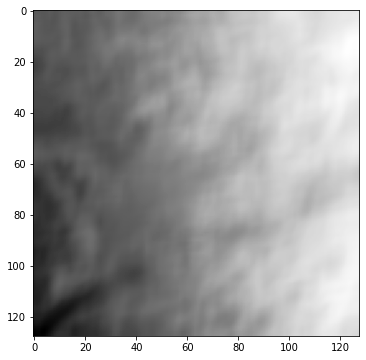

In [ ]:
from rasterio.plot import show
import matplotlib.pyplot as plt

dem_array = val_lr[0][0].numpy().squeeze()
 
fig, ax = plt.subplots(1, figsize=(6, 6))
show(dem_array, cmap='Greys_r', ax=ax)
plt.show()

In [ ]:
from ignite.metrics import PSNR,SSIM
from ignite.engine import Engine
# from imresize import numeric_kernel

def eval_step(engine, batch): 
    return batch 
def calculate_error(img1,img2):
    
    default_evaluator = Engine(eval_step)
    # calculating PSNR 
    y1 = img1.to("cuda")
    y2 = img2.to("cuda")
    psnr = PSNR(data_range=1)
    psnr.attach(default_evaluator,'psnr')
    state1 = default_evaluator.run([[y1,y2]])
    # print(f"PSNR :{state1.metrics['psnr']}")

    # # calculating SSIM
    y1,y2 = torch.tensor(y1,dtype=torch.float32),torch.tensor(y2,dtype=torch.float32)
    metric = SSIM(data_range=1)
    metric.attach(default_evaluator, 'ssim')
    state2 = default_evaluator.run([[y1, y2]])


    # print(f"SSIM : {state2.metrics['ssim']}")
    return state1.metrics['psnr'],state2.metrics['ssim']

## Model parameters 

In [ ]:
generator = RRDBNet(1, 1, 64, 4)
generator = generator.to("cuda")
discriminator = Discriminator_VGG_128(1,64)
discriminator = discriminator.to("cuda")

optim_G = torch.optim.Adam(generator.parameters(), lr=0.0001)
optim_D = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
# LR Scheduling

In [ ]:
# del generator
# del discriminator

In [ ]:
# from numba import cuda
# # Clearing GPU RAM
# cuda.select_device(0)
# cuda.close()

In [ ]:
! nvidia-smi

Sat Jul  2 11:59:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    33W / 250W |   1043MiB / 16280MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Gradient Penalty

In [21]:


def gradient_penalty(critic, real, fake, device):
  batch_size, c, h, w = real.shape
  alpha = torch.randn((batch_size, 1, 1, 1)).repeat(1, c, h, w).to(device)
  interplorated_images = real * real + fake.detach() * (1 - alpha)
  interplorated_images.requires_grad_(True)

  mixed_scores = discriminator(interplorated_images)

  gradient = torch.autograd(
      inputs = interplorated_images,
      outputs = mixed_scores,
      grad_outputs = torch.ones_like(mixed_scores),
      create_graph = True,
      retain_graph = True,
  )[0]

  gradient = gradient.view(gradient.shape[0], -1)
  gradient_norm = gradient.norm(2, dim=1)
  gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
  return gradient_penalty




## Training Loop

In [ ]:
from tqdm import tqdm
import wandb

wandb.init(project="sr-gan")
num_epochs = 250
num_train_batches = float(len(dl))
num_val_batches = float(len(val_lr))

for epoch in range(num_epochs):
    print(f"Epoch {epoch}: ", end ="")
    
    G_adv_loss = 0
    G_rec_loss = 0
    G_tot_loss = 0
    D_adv_loss = 0
    
    generator.train()
    for batch in tqdm(dl):

      for p in discriminator.parameters():
        p.requires_grad = False
        #training generator
      optim_G.zero_grad()

      batch_lr = batch['LR']
      batch_hr = batch['HR'] 
      lr_images = batch_lr.to("cuda")
      hr_images = batch_hr.to("cuda")
      predicted_hr_images = generator(lr_images)
      predicted_hr_labels = discriminator(predicted_hr_images)
      gf_loss = F.binary_cross_entropy_with_logits(predicted_hr_labels, torch.ones_like(predicted_hr_labels)) #adverserial loss
      # reconstruction loss
      # gr_loss = 100*F.l1_loss(predicted_hr_images, hr_images) # L1 loss
      gr_loss = 100*F.mse_loss(predicted_hr_images, hr_images) # L2 loss
      g_loss = gf_loss + gr_loss

      G_adv_loss += gf_loss.item()
      G_rec_loss += gr_loss.item()
      G_tot_loss += g_loss.item()
      
      g_loss.backward()
      optim_G.step()
      #training discriminator
      for p in discriminator.parameters():
        p.requires_grad = True
      optim_D.zero_grad()
      predicted_hr_images = generator(lr_images).detach() # avoid back propogation to generator
      adv_hr_real = discriminator(hr_images)
      adv_hr_fake = discriminator(predicted_hr_images)
      df_loss = F.binary_cross_entropy_with_logits(adv_hr_real, torch.ones_like(adv_hr_real)) + F.binary_cross_entropy_with_logits(adv_hr_fake, torch.zeros_like(adv_hr_fake))
      D_adv_loss += df_loss.item()
      df_loss.backward()
      optim_D.step()
    
    wandb.log({"G Adversarial Loss": G_adv_loss/num_train_batches, 'epoch':epoch })
    wandb.log({"G Reconstruction Loss": G_rec_loss/num_train_batches, 'epoch':epoch })
    wandb.log({"G Loss Total": G_tot_loss/num_train_batches, 'epoch':epoch })
    wandb.log({"D Adversarial Loss": D_adv_loss/num_train_batches, 'epoch':epoch })


    #After each epoch, we perform validation
    with torch.inference_mode():
      val_psnr = 0
      val_ssim = 0
      for batch_idx, (lr, hr) in enumerate(zip(val_lr, val_hr)):
        lr = lr.to("cuda")
        hr = hr.to("cuda")
        predicted_hr = generator(lr)

        psnr, ssim = calculate_error(hr, predicted_hr)
        val_psnr += psnr
        val_ssim += ssim

        grid1 = make_grid(lr)
        grid2 = make_grid(hr)
        grid3 = make_grid(predicted_hr)
        grid1 = wandb.Image(grid1, caption="Low Resolution Image")
        grid2 = wandb.Image(grid2, caption="High Resolution Image")
        grid3 = wandb.Image(grid3, caption="Reconstructed High Resolution Image")
        wandb.log({"Original LR": grid1})
        wandb.log({"Original HR": grid2})
        wandb.log({"Reconstruced": grid3})
    
    val_psnr /= num_val_batches
    val_ssim /= num_val_batches
    wandb.log({"PSNR" : val_psnr, 'epoch':epoch })
    wandb.log({"SSIM" : val_ssim, 'epoch':epoch })
    print(f"PSNR: {val_psnr:.3f} SSIM: {val_ssim:.3f}\n")

wandb: Currently logged in as: m-abbas-ansari. Use `wandb login --relogin` to force relogin


Epoch 0: 

100%|██████████| 5/5 [00:21<00:00,  4.31s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


PSNR: 13.260 SSIM: 0.557

Epoch 1: 

100%|██████████| 5/5 [00:20<00:00,  4.02s/it]


PSNR: 14.894 SSIM: 0.615

Epoch 2: 

100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


PSNR: 18.817 SSIM: 0.650

Epoch 3: 

100%|██████████| 5/5 [00:21<00:00,  4.20s/it]


PSNR: 19.221 SSIM: 0.567

Epoch 4: 

100%|██████████| 5/5 [00:21<00:00,  4.27s/it]


PSNR: 17.936 SSIM: 0.556

Epoch 5: 

100%|██████████| 5/5 [00:20<00:00,  4.01s/it]


PSNR: 13.595 SSIM: 0.537

Epoch 6: 

100%|██████████| 5/5 [00:21<00:00,  4.33s/it]


PSNR: 10.165 SSIM: 0.483

Epoch 7: 

100%|██████████| 5/5 [00:20<00:00,  4.05s/it]


PSNR: 9.514 SSIM: 0.435

Epoch 8: 

100%|██████████| 5/5 [00:20<00:00,  4.00s/it]


PSNR: 10.514 SSIM: 0.419

Epoch 9: 

100%|██████████| 5/5 [00:17<00:00,  3.54s/it]


PSNR: 12.571 SSIM: 0.444

Epoch 10: 

100%|██████████| 5/5 [00:22<00:00,  4.46s/it]


PSNR: 15.610 SSIM: 0.481

Epoch 11: 

100%|██████████| 5/5 [00:21<00:00,  4.39s/it]


PSNR: 16.403 SSIM: 0.477

Epoch 12: 

100%|██████████| 5/5 [00:17<00:00,  3.58s/it]


PSNR: 16.157 SSIM: 0.451

Epoch 13: 

100%|██████████| 5/5 [00:21<00:00,  4.31s/it]


PSNR: 14.606 SSIM: 0.411

Epoch 14: 

100%|██████████| 5/5 [00:19<00:00,  3.98s/it]


PSNR: 12.189 SSIM: 0.369

Epoch 15: 

100%|██████████| 5/5 [00:16<00:00,  3.40s/it]


PSNR: 11.432 SSIM: 0.346

Epoch 16: 

100%|██████████| 5/5 [00:15<00:00,  3.11s/it]


PSNR: 11.118 SSIM: 0.334

Epoch 17: 

100%|██████████| 5/5 [00:16<00:00,  3.35s/it]


PSNR: 11.308 SSIM: 0.315

Epoch 18: 

100%|██████████| 5/5 [00:16<00:00,  3.26s/it]


PSNR: 12.008 SSIM: 0.279

Epoch 19: 

100%|██████████| 5/5 [00:18<00:00,  3.73s/it]


PSNR: 11.456 SSIM: 0.237

Epoch 20: 

100%|██████████| 5/5 [00:16<00:00,  3.37s/it]


PSNR: 14.048 SSIM: 0.204

Epoch 21: 

100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


PSNR: 10.858 SSIM: 0.168

Epoch 22: 

100%|██████████| 5/5 [00:21<00:00,  4.21s/it]


PSNR: 10.403 SSIM: 0.167

Epoch 23: 

100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


PSNR: 13.203 SSIM: 0.188

Epoch 24: 

100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


PSNR: 13.417 SSIM: 0.211

Epoch 25: 

100%|██████████| 5/5 [00:17<00:00,  3.52s/it]


PSNR: 12.051 SSIM: 0.223

Epoch 26: 

100%|██████████| 5/5 [00:15<00:00,  3.12s/it]


PSNR: 11.674 SSIM: 0.245

Epoch 27: 

100%|██████████| 5/5 [00:15<00:00,  3.15s/it]


PSNR: 11.675 SSIM: 0.304

Epoch 28: 

100%|██████████| 5/5 [00:16<00:00,  3.33s/it]


PSNR: 12.608 SSIM: 0.379

Epoch 29: 

100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


PSNR: 15.278 SSIM: 0.519

Epoch 30: 

100%|██████████| 5/5 [00:15<00:00,  3.06s/it]


PSNR: 22.294 SSIM: 0.804

Epoch 31: 

100%|██████████| 5/5 [00:15<00:00,  3.05s/it]


PSNR: 20.586 SSIM: 0.664

Epoch 32: 

100%|██████████| 5/5 [00:18<00:00,  3.64s/it]


PSNR: 26.960 SSIM: 0.894

Epoch 33: 

100%|██████████| 5/5 [00:15<00:00,  3.00s/it]


PSNR: 14.856 SSIM: 0.638

Epoch 34: 

100%|██████████| 5/5 [00:16<00:00,  3.24s/it]


PSNR: 13.131 SSIM: 0.589

Epoch 35: 

100%|██████████| 5/5 [00:18<00:00,  3.74s/it]


PSNR: 14.525 SSIM: 0.631

Epoch 36: 

100%|██████████| 5/5 [00:15<00:00,  3.00s/it]


PSNR: 22.278 SSIM: 0.834

Epoch 37: 

100%|██████████| 5/5 [00:16<00:00,  3.29s/it]


PSNR: 28.552 SSIM: 0.919

Epoch 38: 

100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


PSNR: 26.892 SSIM: 0.915

Epoch 39: 

100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


PSNR: 24.748 SSIM: 0.896

Epoch 40: 

100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


PSNR: 16.478 SSIM: 0.569

Epoch 41: 

100%|██████████| 5/5 [00:16<00:00,  3.36s/it]


PSNR: 12.343 SSIM: 0.265

Epoch 42: 

100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


PSNR: 13.056 SSIM: 0.104

Epoch 43: 

100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


PSNR: 12.756 SSIM: 0.263

Epoch 44: 

100%|██████████| 5/5 [00:18<00:00,  3.62s/it]


PSNR: 12.955 SSIM: 0.342

Epoch 45: 

100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


PSNR: 13.530 SSIM: 0.374

Epoch 46: 

100%|██████████| 5/5 [00:15<00:00,  3.07s/it]


PSNR: 14.582 SSIM: 0.424

Epoch 47: 

100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


PSNR: 14.969 SSIM: 0.449

Epoch 48: 

100%|██████████| 5/5 [00:17<00:00,  3.50s/it]


PSNR: 12.819 SSIM: 0.349

Epoch 49: 

100%|██████████| 5/5 [00:16<00:00,  3.30s/it]


PSNR: 12.828 SSIM: 0.318

Epoch 50: 

100%|██████████| 5/5 [00:17<00:00,  3.54s/it]


PSNR: 15.749 SSIM: 0.494

Epoch 51: 

100%|██████████| 5/5 [00:16<00:00,  3.33s/it]


PSNR: 15.464 SSIM: 0.494

Epoch 52: 

100%|██████████| 5/5 [00:17<00:00,  3.45s/it]


PSNR: 15.858 SSIM: 0.497

Epoch 53: 

100%|██████████| 5/5 [00:17<00:00,  3.55s/it]


PSNR: 14.433 SSIM: 0.323

Epoch 54: 

100%|██████████| 5/5 [00:17<00:00,  3.44s/it]


PSNR: 15.326 SSIM: 0.234

Epoch 55: 

100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


PSNR: 14.254 SSIM: 0.130

Epoch 56: 

100%|██████████| 5/5 [00:15<00:00,  3.03s/it]


PSNR: 14.713 SSIM: 0.063

Epoch 57: 

100%|██████████| 5/5 [00:15<00:00,  3.02s/it]


PSNR: 14.497 SSIM: 0.119

Epoch 58: 

100%|██████████| 5/5 [00:16<00:00,  3.26s/it]


PSNR: 14.816 SSIM: 0.193

Epoch 59: 

100%|██████████| 5/5 [00:17<00:00,  3.48s/it]


PSNR: 16.033 SSIM: 0.236

Epoch 60: 

100%|██████████| 5/5 [00:16<00:00,  3.32s/it]


PSNR: 16.494 SSIM: 0.215

Epoch 61: 

100%|██████████| 5/5 [00:18<00:00,  3.76s/it]


PSNR: 16.155 SSIM: 0.143

Epoch 62: 

100%|██████████| 5/5 [00:19<00:00,  3.86s/it]


PSNR: 15.590 SSIM: 0.114

Epoch 63: 

100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


PSNR: 15.843 SSIM: 0.099

Epoch 64: 

100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


PSNR: 16.445 SSIM: 0.079

Epoch 65: 

100%|██████████| 5/5 [00:20<00:00,  4.13s/it]


PSNR: 16.548 SSIM: 0.090

Epoch 66: 

100%|██████████| 5/5 [00:22<00:00,  4.57s/it]


PSNR: 16.373 SSIM: 0.084

Epoch 67: 

100%|██████████| 5/5 [00:20<00:00,  4.08s/it]


PSNR: 16.672 SSIM: 0.087

Epoch 68: 

100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


PSNR: 17.103 SSIM: 0.128

Epoch 69: 

100%|██████████| 5/5 [00:19<00:00,  3.96s/it]


PSNR: 21.888 SSIM: 0.645

Epoch 70: 

100%|██████████| 5/5 [00:16<00:00,  3.24s/it]


PSNR: 18.560 SSIM: 0.591

Epoch 71: 

100%|██████████| 5/5 [00:22<00:00,  4.40s/it]


PSNR: 24.976 SSIM: 0.659

Epoch 72: 

100%|██████████| 5/5 [00:20<00:00,  4.20s/it]


PSNR: 20.667 SSIM: 0.508

Epoch 73: 

100%|██████████| 5/5 [00:23<00:00,  4.67s/it]


PSNR: 19.519 SSIM: 0.407

Epoch 74: 

100%|██████████| 5/5 [00:17<00:00,  3.55s/it]


PSNR: 16.372 SSIM: 0.274

Epoch 75: 

100%|██████████| 5/5 [00:21<00:00,  4.25s/it]


PSNR: 12.780 SSIM: 0.128

Epoch 76: 

100%|██████████| 5/5 [00:20<00:00,  4.05s/it]


PSNR: 12.804 SSIM: 0.108

Epoch 77: 

100%|██████████| 5/5 [00:17<00:00,  3.60s/it]


PSNR: 13.315 SSIM: 0.128

Epoch 78: 

100%|██████████| 5/5 [00:19<00:00,  3.89s/it]


PSNR: 13.969 SSIM: 0.188

Epoch 79: 

100%|██████████| 5/5 [00:21<00:00,  4.32s/it]


PSNR: 14.526 SSIM: 0.185

Epoch 80: 

100%|██████████| 5/5 [00:21<00:00,  4.26s/it]


PSNR: 15.204 SSIM: 0.245

Epoch 81: 

100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


PSNR: 15.721 SSIM: 0.263

Epoch 82: 

100%|██████████| 5/5 [00:18<00:00,  3.79s/it]


PSNR: 16.035 SSIM: 0.273

Epoch 83: 

100%|██████████| 5/5 [00:20<00:00,  4.19s/it]


PSNR: 16.168 SSIM: 0.276

Epoch 84: 

100%|██████████| 5/5 [00:19<00:00,  3.85s/it]


PSNR: 16.023 SSIM: 0.269

Epoch 85: 

100%|██████████| 5/5 [00:18<00:00,  3.64s/it]


PSNR: 15.520 SSIM: 0.239

Epoch 86: 

100%|██████████| 5/5 [00:19<00:00,  3.95s/it]


PSNR: 15.090 SSIM: 0.226

Epoch 87: 

100%|██████████| 5/5 [00:18<00:00,  3.62s/it]


PSNR: 14.826 SSIM: 0.206

Epoch 88: 

100%|██████████| 5/5 [00:14<00:00,  3.00s/it]


PSNR: 14.926 SSIM: 0.196

Epoch 89: 

100%|██████████| 5/5 [00:16<00:00,  3.27s/it]


PSNR: 15.201 SSIM: 0.198

Epoch 90: 

100%|██████████| 5/5 [00:17<00:00,  3.45s/it]


PSNR: 14.736 SSIM: 0.146

Epoch 91: 

100%|██████████| 5/5 [00:19<00:00,  3.94s/it]


PSNR: 14.596 SSIM: 0.040

Epoch 92: 

100%|██████████| 5/5 [00:16<00:00,  3.40s/it]


PSNR: 16.900 SSIM: 0.012

Epoch 93: 

100%|██████████| 5/5 [00:18<00:00,  3.77s/it]


PSNR: 16.900 SSIM: 0.012

Epoch 94: 

100%|██████████| 5/5 [00:20<00:00,  4.12s/it]


PSNR: 16.900 SSIM: 0.012

Epoch 95: 

100%|██████████| 5/5 [00:20<00:00,  4.14s/it]


PSNR: 16.900 SSIM: 0.012

Epoch 96: 

100%|██████████| 5/5 [00:18<00:00,  3.78s/it]


PSNR: 16.900 SSIM: 0.012

Epoch 97: 

100%|██████████| 5/5 [00:19<00:00,  3.84s/it]


PSNR: 16.900 SSIM: 0.012

Epoch 98: 

100%|██████████| 5/5 [00:18<00:00,  3.76s/it]


PSNR: 16.900 SSIM: 0.012

Epoch 99: 

100%|██████████| 5/5 [00:23<00:00,  4.66s/it]


PSNR: 16.900 SSIM: 0.012

Epoch 100: 

100%|██████████| 5/5 [00:17<00:00,  3.46s/it]


PSNR: 16.900 SSIM: 0.012

Epoch 101: 

100%|██████████| 5/5 [00:18<00:00,  3.78s/it]


PSNR: 16.900 SSIM: 0.012

Epoch 102: 

100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


PSNR: 16.900 SSIM: 0.012

Epoch 103: 

 60%|██████    | 3/5 [00:15<00:10,  5.16s/it]

In [ ]:
!ps -aux|grep python

In [ ]:
!kill -9 1063

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

## VAE

In [ ]:
generator = RRDBNet(1, 1, 64, 4)
generator = generator.to("cuda")
optim_G = torch.optim.Adam(generator.parameters(), lr=0.0001)

In [ ]:
wandb.init(project="vae")
for epoch in range(1, 10):
    print("Training for epoch",epoch)
    generator.train()
    start_index = 0
    for batchIndex in range(0,num_iterations):
      print("iteration", batchIndex)
      end_index = min(start_index+10,len(train_lr_dataset))
      #training generator
      optim_G.zero_grad()
      batch_lr = train_preprocess_function(train_lr_dataset[start_index:end_index])
      batch_hr = train_preprocess_function(train_hr_dataset[start_index:end_index])
      start_index = end_index
      #batch_lr = 
      lr_images = batch_lr.to("cuda")
      hr_images = batch_hr.to("cuda")
      predicted_hr_images = generator(lr_images)
      g_loss = 100.0* F.l1_loss(predicted_hr_images, hr_images)
      wandb.log({"G Loss Total":g_loss.item()})
      g_loss.backward()
      optim_G.step()
      if batchIndex%5==0:
        grid1 = make_grid(lr_images[0:3])
        grid2 = make_grid(hr_images[0:3])
        grid3 = make_grid(predicted_hr_images[0:3])
        grid1 = wandb.Image(grid1, caption="Low Resolution Image")
        grid2 = wandb.Image(grid2, caption="High Resolution Image")
        grid3 = wandb.Image(grid3, caption="Reconstructed High Resolution Image")
        wandb.log({"Original LR": grid1})
        wandb.log({"Original HR": grid2})
        wandb.log({"Reconstruced": grid3})